In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from  tqdm import tqdm, trange
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
from time import perf_counter_ns, time_ns
from collections import defaultdict

from clf_funcs import setup

setup(1200)

2025-02-05 19:40:35.097256: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


/home/mihawb/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-05 19:40:59.540026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-05 19:40:59.599049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-05 19:40:59.599684: I tensorflow/compiler/xla/stream_execu

In [2]:
class PerfCounterCallback(tf.keras.callbacks.Callback):
  def __init__(self, latency_ref):
    super().__init__()
    self.latency_ref = latency_ref

  def on_predict_begin(self, logs=None):
    self.pred_start = perf_counter_ns()

  def on_predict_end(self, logs=None):
    self.pred_end = perf_counter_ns()
    elapsed = self.pred_end - self.pred_start
    self.latency_ref.append(elapsed)


class Coco2017Dataset:
  def __init__(self, img_dir: str, transform=None) -> None:
    assert (p := Path(img_dir)).exists() and p.is_dir(), f"Image directory {img_dir} does not exist"
    self.img_paths = [str(p) for p in Path(img_dir).glob("*.jpg")]
    self.transform = transform

  def __len__(self) -> int:
    return len(self.img_paths)

  def __getitem__(self, idx: int) -> tf.Tensor:
    img_path = self.img_paths[idx]
    with tf.device("/device:GPU:0"):
      image = tf.io.read_file(img_path)
      image = tf.image.decode_jpeg(image, channels=3)
      image = tf.cast(image, tf.float32) / 255
      image = tf.image.resize(image, (640, 640), antialias=True)
    return image

2025-02-05 19:40:59.801961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-05 19:40:59.802412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-05 19:40:59.802768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

1738780878516461068


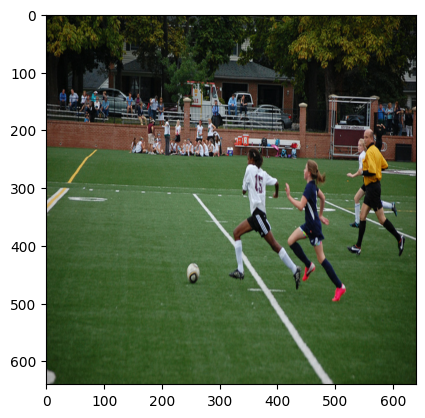

In [3]:
perf_callback = PerfCounterCallback(latency_ref=[])

coco_ds = Coco2017Dataset(img_dir="../../datasets/coco2017_val")
plt.imshow(coco_ds[0])

timestamp = time_ns()
print(timestamp)
results_filepath = f'../../results_ultimate_0/tensorflow-yolo-{timestamp}.csv'
telemetry = defaultdict(list)

In [5]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_m_backbone_coco", load_weights=True)
model = keras_cv.models.YOLOV8Detector(num_classes=80, bounding_box_format="xyxy", backbone=backbone, fpn_depth=1)

/home/mihawb/.local/lib/python3.11/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/mihawb/.local/lib/python3.11/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [6]:
perf_callback.latency_ref.clear()
for i, img in enumerate(tqdm(coco_ds, desc="Benchmark"), start=1):
  with tf.device("/device:GPU:0"):
    img = tf.expand_dims(img, axis=0)
  assert "GPU" in img.device
  _ = model.predict(img, callbacks=[perf_callback], verbose=0)

  telemetry["framework"].append("TensorFlow")
  telemetry["model_name"].append("YOLOv8m")
  telemetry["phase"].append("latency")
  telemetry["epoch"].append(i)
  telemetry["loss"].append(-1)
  telemetry["performance"].append(-1)
telemetry["elapsed_time"].extend(perf_callback.latency_ref)
pd.DataFrame(telemetry).to_csv(results_filepath, index=False)

Benchmark:  41%|████      | 2045/5000 [08:59<19:01:50, 23.18s/it]